In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2-1. 데이터 로드 및 전처리 스크립트
> zipfile 라이브러리 사용해 압축 파일 내부의 이미지에 접근하고, 필요한 전처리 작업(이미지 크기 조정, 정규화 등)을 수행합니다.

#### 2-1-1. 데이터 로드
- ZIP 파일에 접근해 파일 내의 모든 파일 목록을 출력해 어떤 파일들이 포함되어 있는지 확인합니다.

In [2]:
import zipfile
import cv2
import numpy as np
import io

def list_zip_contents(zip_path, num_files):
    with zipfile.ZipFile(zip_path, 'r') as z:
        print("Files in the ZIP archive:")
        file_list = z.namelist()
        for file in file_list[:num_files]:
            print(file)

# ZIP 파일 내용 확인
zip_path = '/content/drive/My Drive/project_classification-DL/data/raw/dataset_MechanicalParts.zip'
list_zip_contents(zip_path, 5)

Files in the ZIP archive:
dataset/testing/bolt/00_09_0101_0100_0400_10.png
dataset/testing/bolt/00_09_0101_0100_0400_14.png
dataset/testing/bolt/00_09_0101_0100_0400_5.png
dataset/testing/bolt/00_09_0101_0100_0450_9.png
dataset/testing/bolt/00_09_0101_0100_0500_20.png


#### 2-1-2. 데이터 구분
- 파일 내 이미지 데이터와 라벨 데이터를 구분해 저장합니다
> 이미지 데이터의 경우, 정규화를 진행한 뒤 저장합니다.

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_and_preprocess_images(zip_path, output_size=(224, 224)):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # 파일 목록을 필터링하여 이미지 파일만 선택
        image_files = [f for f in z.namelist() if f.endswith(('.png', '.jpg', '.jpeg'))]
        images = []
        labels = []

        for filename in image_files:
            # 이미지 파일을 메모리로 직접 로드
            with z.open(filename) as file:
                content = io.BytesIO(file.read())
                image = load_img(content, target_size=output_size)
                image = img_to_array(image)
                images.append(image)

            # 이미지 파일 경로에서 'mechanical_parts nut' 부분의 'nut' 추출
            label = filename.split('/')[2]  # '/'로 분할하고 세 번째 요소(인덱스 2)를 선택
            labels.append(label)

        # 이미지와 라벨을 배열로 변환
        images = np.array(images, dtype='float32') / 255.0 # 정규화
        labels = np.array(labels)
        return images, labels

In [4]:
# 사용 예
zip_path = '/content/drive/My Drive/project_classification-DL/data/raw/dataset_MechanicalParts.zip'
images, labels = load_and_preprocess_images(zip_path)
print("Loaded images shape:", images.shape)
print("Loaded labels:", labels[:10])  # 첫 10개의 라벨을 출력

Loaded images shape: (7616, 224, 224, 3)
Loaded labels: ['bolt' 'bolt' 'bolt' 'bolt' 'bolt' 'bolt' 'bolt' 'bolt' 'bolt' 'bolt']


In [5]:
# 유니크 라벨과 그 빈도 계산
unique_labels, counts = np.unique(labels, return_counts=True)

# 결과 출력
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: bolt, Count: 1904
Label: locatingpin, Count: 1904
Label: nut, Count: 1904
Label: washer, Count: 1904


#### ex) 몇 개의 예시 이미지에 대한 확인
> matplotlib 라이브러리를 사용해 이미지를 플롯함

In [6]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=5):
    # 이미지와 라벨 수 중 최소값으로 제한
    num_images = min(len(images), len(labels), num_images)

    plt.figure(figsize=(15, 15))  # 전체 플롯 크기 설정
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)  # 각 이미지마다 새로운 subplot 생성
        img_display = (images[i] * 255).astype('uint8')
        ax.imshow(img_display)  # 현재의 subplot에 이미지를 표시
        ax.set_title(labels[i])  # 각 subplot의 제목을 라벨명으로 설정
        ax.axis("off")  # 축 표시 제거
    plt.show()

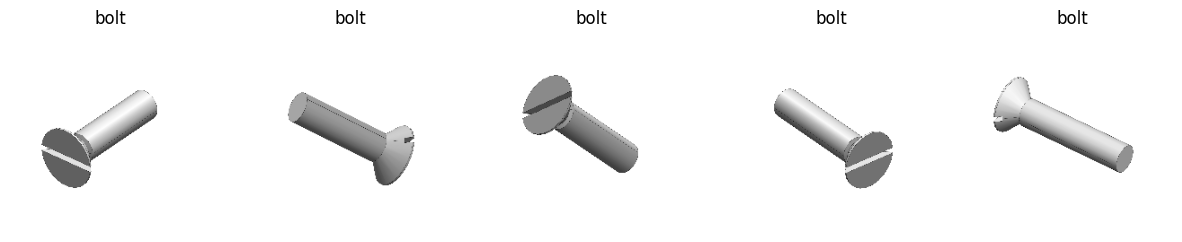

In [7]:
# 로드된 이미지 배열 'images'와 라벨 배열 'labels'에서 5개의 이미지와 라벨을 표시
show_images(images, labels, num_images=5)

#### 2-1-3. 라벨 데이터의 인코딩
- 딥러닝 모델에서 분류 작업을 수행할 때, 라벨은 일반적으로 정수 형태의 인덱스로 인코딩되어야 합니다.
> 따라서 문자열 라벨을 적절한 정수 형태로 변환하는 과정이 필요합니다.

In [8]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 초기화
label_encoder = LabelEncoder()

# 라벨 인코딩 수행
encoded_labels = label_encoder.fit_transform(labels)
print("Encoded labels:", encoded_labels)  # 변환된 정수 인덱스를 출력

Encoded labels: [0 0 0 ... 3 3 3]


#### 2-1-4. 정수형 라벨 데이터의 원-핫 인코딩 형식으로의 변환
- 원-핫 인코딩 방식은 특히 다중 클래스 분류 문제에서 다음과 같은 여러 가지 장점을 갖습니다.
    - 명확한 클래스 분리 > 원-핫 인코딩은 각 클래스를 서로 독립적인 축으로 표현합니다.
    > 이는 모델이 각 클래스 사이의 경계를 더 명확하게 학습하는 데 도움을 줄 수 있으며, 각 클래스에 대한 예측 확률을 직관적으로 해석할 수 있도록 합니다.
    - 오류 함수의 적용 > 원-핫 인코딩을 사용하면 categorical_crossentropy 손실 함수를 사용할 수 있습니다.
    > 이 손실 함수는 모델의 출력과 실제 라벨 사이의 확률 분포 차이를 효과적으로 측정하며, 이는 특히 확률적 결과를 다루는 딥러닝 모델에서 중요합니다.
    - Precision, Recall, F1 Score 계산 용이 > 원-핫 인코딩을 사용하면 각 클래스별로 Precision, Recall, 그리고 F1 Score 같은 성능 지표를 계산하기 쉽습니다.
    > 이 메트릭들은 모델의 성능을 다각도로 평가하는 데 중요하며, 특히 불균형 데이터셋에서 모델의 성능을 정확히 이해하는 데 도움을 줍니다.
    - 확장성과 호환성 > 많은 기계 학습 및 딥러닝 라이브러리와 도구들이 원-핫 인코딩을 사용하도록 설계되어 있습니다.
    > 이는 코드의 호환성과 확장성을 높이며, 다른 시스템이나 프로젝트로 모델을 이전할 때 발생할 수 있는 문제를 줄여줍니다.

In [9]:
from tensorflow.keras.utils import to_categorical

# 라벨의 클래스 수를 확인
num_classes = len(np.unique(encoded_labels))

# 정수 인코딩된 라벨을 원-핫 인코딩으로 변환
one_hot_labels = to_categorical(encoded_labels, num_classes=num_classes)
print("One_hot_labels:", one_hot_labels)

One_hot_labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


#### 2-1-5. 이미지 데이터 정규화
- 정규화 및 표준화의 영향
  - 효율적인 학습 > 데이터의 스케일을 조정함으로써 모델의 학습 효율을 향상시키고, 더 빠른 수렴을 도울 수 있습니다.
  - 수치 안정성 > 입력 데이터의 범위를 0과 1 사이로 조정하거나 평균이 0이고 표준편차가 1인 분포로 조정함으로써, 수치적으로 더 안정된 계산을 할 수 있습니다.

(아래 코드는 정규화가 정상적으로 되었는지 확인하는 과정입니다.)


In [10]:
import numpy as np

def check_image_normalization(images):
    # 이미지 데이터의 최소값과 최대값을 계산
    min_val = np.min(images)
    max_val = np.max(images)

    # 최소값과 최대값을 출력
    print(f"Minimum value in the image data: {min_val}")
    print(f"Maximum value in the image data: {max_val}")

    # 정규화 여부 확인
    if min_val >= 0 and max_val <= 1:
        print("The image data is normalized between 0 and 1.")
    elif min_val >= 0 and max_val <= 255:
        print("The image data might be in the range of 0 to 255.")
    else:
        print("The image data is not normalized, or it is scaled to another range.")

# 이미지 데이터 예시
# images 변수는 이미 로드된 이미지 데이터 배열을 가정
# 예를 들어, 이미지 데이터 로드: images = np.load('/path/to/your/images.npy')

# 이미지 데이터 정규화 여부 확인
check_image_normalization(images)

Minimum value in the image data: 0.0
Maximum value in the image data: 1.0
The image data is normalized between 0 and 1.


#### 2-1-6. 데이터 증강
> 데이터 증강은 모델이 다양한 형태의 데이터에 대해 일반화할 수 있도록 도와줍니다.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 generator 설정
data_gen = ImageDataGenerator(
    rotation_range=40, # 0-40도 사이에서 랜덤하게 이미지를 회전
    width_shift_range=0.2, # 이미지를 수평으로 최대 20% 이동
    height_shift_range=0.2, # 이미지를 수직으로 최대 20% 이동
    shear_range=0.2, # 이미지를 20% 이내로 찌그러트림
    zoom_range=0.2, # 20% 이내로 확대/祝疏
    horizontal_flip=True, # 수평 방향으로 이미지를 뒤집음
    #brightness_range=[0.8, 1.2],  # 밝기 조정
    #channel_shift_range=50.0,     # 채널 값 조정
    fill_mode='nearest'  # 회전 또는 너비/높이 이동으로 생성된 공백을 가까운 픽셀 값으로 채움
)

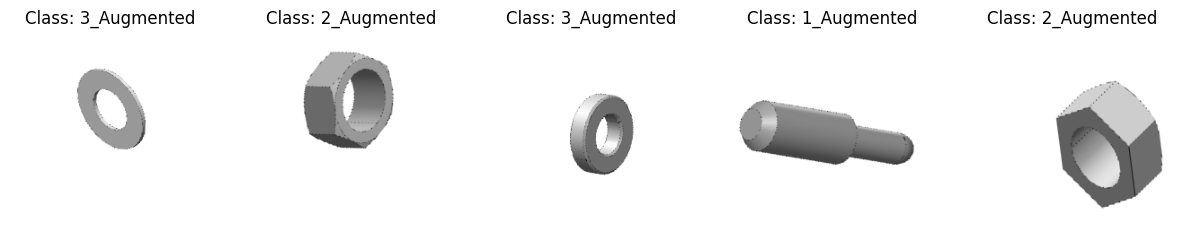

In [12]:
import matplotlib.pyplot as plt

augmented_images = data_gen.flow(images, one_hot_labels, batch_size=32)  # 배치 사이즈를 설정하여 데이터 증강 적용

def show_augmented_images(augmented_images, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        batch = next(augmented_images)
        img = batch[0][0]  # 첫 번째 이미지
        label = batch[1][0]  # 첫 번째 라벨

        # 이미지를 원래의 스케일 [0, 255]로 되돌리기
        img_display = (img * 255).astype('uint8')

        label_index = np.argmax(label)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_display)
        plt.title(f"Class: {label_index}_Augmented")
        plt.axis('off')
    plt.show()

# 증강된 이미지 5개를 표시하는 함수 호출
show_augmented_images(augmented_images)

#### 2-1-7. 전처리된 이미지 데이터의 저장

In [13]:
import numpy as np
import os

# 저장할 디렉토리 생성
processed_dir = '/content/drive/My Drive/project_classification-DL/data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

def save_processed_data(images, labels, directory):
    # 이미지와 라벨 데이터를 압축하여 저장합니다.
    file_path = os.path.join(directory, 'processed_data.npz')  # 확장자를 .npz로 지정
    np.savez_compressed(file_path, images=images, labels=labels)
    print("Data saved successfully in compressed format.")

# 저장 실행
save_processed_data(images, one_hot_labels, processed_dir)

Data saved successfully in compressed format.


### 2-2. 데이터 분할
- 모델 훈련을 위해 데이터를 훈련(70%), 검증(15%), 테스트(15%) 데이터셋으로 분할합니다.
    - 훈련 세트 > 모델 학습에 사용합니다.
    - 검증 세트 > 학습 중 모델의 하이퍼파라미터를 조정하고, 학습 진행 상황을 평가하기 위해 사용합니다.
    - 테스트 세트 > 모델 학습을 완료한 후, 모델의 성능을 최종적으로 평가합니다.